**Author: Fiona Jiaqi Wu** 

In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Datasets

In [3]:
df1 = pd.read_csv('/Users/Fiona/Desktop/Prosper/2019.csv')

In [4]:
df1.shape

(189941, 370)

In [5]:
df2 = pd.read_csv('/Users/Fiona/Desktop/Prosper/2020.csv')

In [6]:
df2.shape

(83747, 377)

In [7]:
df3 = pd.read_csv('/Users/Fiona/Desktop/Prosper/2018.csv')

In [8]:
df1['listing_start_date'] = pd.to_datetime(df1['listing_start_date'])
df1['listing_end_date'] = pd.to_datetime(df1['listing_end_date'])
df1['listing_creation_date'] = pd.to_datetime(df1['listing_creation_date'])
df2['listing_start_date'] = pd.to_datetime(df2['listing_start_date'])
df2['listing_end_date'] = pd.to_datetime(df2['listing_end_date'])
df2['listing_creation_date'] = pd.to_datetime(df2['listing_creation_date'])
df3['listing_start_date'] = pd.to_datetime(df3['listing_start_date'])
df3['listing_end_date'] = pd.to_datetime(df3['listing_end_date'])
df3['listing_creation_date'] = pd.to_datetime(df3['listing_creation_date'])

### Combine datasets (2018, 2019, 2020)

In [9]:
df1 = df1[df1.columns & df2.columns & df3.columns]
df2 = df2[df1.columns & df2.columns & df3.columns]
df3 = df3[df1.columns & df2.columns & df3.columns]

In [10]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df1.shape[0] + df2.shape[0] + df3.shape[0])

(189941, 368)
(83747, 368)
(227524, 368)
501212


In [11]:
combined = pd.concat([df1, df2, df3], ignore_index=True)

In [12]:
combined.shape

(501212, 368)

### Data Cleaning (dealing with NaN values)

In [13]:
combined = combined.loc[combined['AT01S'].isnull() == False]
combined = combined.loc[combined['RT35S'].isnull() == False]
combined.shape

(500367, 368)

In [14]:
#fill missing prosper scores with its median
prosper_median = combined['prosper_score'].median()
combined['prosper_score'] = combined['prosper_score'].fillna(prosper_median)

In [15]:
#replace the missing values in occupation with the second most common value - professional (the most common one is Other)
combined['occupation'] = combined['occupation'].fillna('Professional')

In [16]:
#fill missing values in months employed with its median
employed_median = combined['months_employed'].median()
combined['months_employed'] = combined['months_employed'].fillna(employed_median)

In [17]:
combined = combined.fillna(0)

In [18]:
#convert percent_funded to % style
combined['percent_funded'] = combined['percent_funded']*100

### Prosper rating 
Prosper Ratings allow potential investors to easily consider a loan application's level of risk because the rating represents an estimated average annualized loss rate range to the investor. 

AA  0.00-1.99% = 6\
A	2.00–3.99% = 5\
B	4.00–5.99% = 4 \
C	6.00–8.99% = 3 \
D	9.00–11.99% = 2\
E	12.00–14.99% = 1 \
HR	≥ 15.00% = 0

In [19]:
#examine the number of ratings in each category
combined['prosper_rating'].value_counts()

B     120145
C     116686
A     114527
AA     66705
D      49711
E      24933
HR      7660
Name: prosper_rating, dtype: int64

In [20]:
#convert categorical varaible - prosper rating to numerical ones (to include them in the model)
def rating_nu(x):
    if x == 'AA':
        return 6
    elif x == 'A':
        return 5
    elif x == 'B':
        return 4
    elif x == 'C':
        return 3 
    elif x == 'D':
        return 2
    elif x == 'E':
        return 1
    elif x == 'HR':
        return 0
    
combined['prosper_rating_nu'] = combined['prosper_rating'].apply(lambda x: rating_nu(x))

### FICO score

In [21]:
#examine the number of individuals in each FICO range
combined['TUFicoRange'].value_counts()

700-719    90163
680-699    86729
720-739    74851
660-679    73824
740-759    52999
640-659    45206
760-779    34106
780-799    23921
800-819    13799
820-850     4769
Name: TUFicoRange, dtype: int64

In [22]:
# convert fico score range to numerical ones, 10 is the highest
def fico_range_nu(x):
    if x == '820-850':
        return 10
    if x == '800-819':
        return 9
    elif x == '780-799':
        return 8
    elif x == '760-779':
        return 7
    elif x == '740-759':
        return 6
    elif x == '720-739':
        return 5
    elif x == '700-719':
        return 4
    elif x == '680-699':
        return 3 
    elif x == '660-679':
        return 2
    elif x == '640-659':
        return 1
    
combined['TUFicoRange_Nu'] = combined['TUFicoRange'].apply(lambda x: fico_range_nu(x))

In [23]:
# convert the rest of the categorical variables into numerical ones
combined['listing_status_reason'] = combined['listing_status_reason'].astype('category')
combined['listing_status_reason_Nu'] = combined['listing_status_reason'].cat.codes
combined['partial_funding_indicator'] = combined['partial_funding_indicator'].astype('category')
combined['partial_funding_indicator_Nu'] = combined['partial_funding_indicator'].cat.codes
combined['employment_status_description'] = combined['employment_status_description'].astype('category')
combined['employment_status_description_Nu'] = combined['employment_status_description'].cat.codes
combined['occupation'] = combined['occupation'].astype('category')
combined['occupation_Nu'] = combined['occupation'].cat.codes
combined['investment_type_description'] = combined['investment_type_description'].astype('category')
combined['investment_type_description_Nu'] = combined['investment_type_description'].cat.codes
combined['CoBorrowerApplication'] = combined['CoBorrowerApplication'].astype('category')
combined['CoBorrowerApplication_Nu'] = combined['CoBorrowerApplication'].cat.codes

In [24]:
print(combined.shape)

(500367, 376)


### Estimated loss rate with defined classes 

In [25]:
# create 10 elr classes with equal intervals
min = 0.002700
max = 0.177500
bins = (0.177500-0.002700) / 10

def elr_class(x):
    if x <= min + bins:
        return 1 
    elif min + bins < x <= min + 2 * bins:
        return 2
    elif min + 2 * bins < x <= min + 3 * bins:
        return 3
    elif min + 3 * bins < x <= min + 4 * bins:
        return 4
    elif min + 4 * bins < x <= min + 5 * bins:
        return 5 
    elif min + 5 * bins < x <= min + 6 * bins:
        return 6
    elif min + 6 * bins < x <= min + 7 * bins:
        return 7
    elif min + 7 * bins < x <= min + 8 * bins:
        return 8
    elif min + 8 * bins < x <= min + 9 * bins:
        return 9
    elif min + 9 * bins < x:
        return 10

combined['elr_bin10_class'] = combined['estimated_loss_rate'].apply(lambda x: elr_class(x))

In [26]:
# create 5 elr classes with equal intervals
bin5 = (0.177500-0.002700) / 5

def elr_class_5(x):
    if x <= min + bin5:
        return 1 
    elif min + bin5 < x <= min + 2 * bin5:
        return 2
    elif min + 2 * bin5 < x <= min + 3 * bin5:
        return 3
    elif min + 3 * bin5 < x <= min + 4 * bin5:
        return 4
    elif min + 4 * bin5 < x:
        return 5 


combined['elr_bin5_class'] = combined['estimated_loss_rate'].apply(lambda x: elr_class_5(x))

In [27]:
bins20 = (0.177500-0.002700) / 20

def elr_class20(x):
    if x <= min + bins20:
        return 1 
    elif min + bins20 < x <= min + 2 * bins20:
        return 2
    elif min + 2 * bins20 < x <= min + 3 * bins20:
        return 3
    elif min + 3 * bins20 < x <= min + 4 * bins20:
        return 4
    elif min + 4 * bins20 < x <= min + 5 * bins20:
        return 5 
    elif min + 5 * bins20 < x <= min + 6 * bins20:
        return 6
    elif min + 6 * bins20 < x <= min + 7 * bins20:
        return 7
    elif min + 7 * bins20 < x <= min + 8 * bins20:
        return 8
    elif min + 8 * bins20 < x <= min + 9 * bins20:
        return 9
    elif min + 9 * bins20 < x <= min + 10 * bins20:
        return 10
    elif min + 10 * bins20 < x <= min + 11 * bins20:
        return 11
    elif min + 11 * bins20 < x <= min + 12 * bins20:
        return 12
    elif min + 12 * bins20 < x <= min + 13 * bins20:
        return 13
    elif min + 13 * bins20 < x <= min + 14 * bins20:
        return 14
    elif min + 14 * bins20 < x <= min + 15 * bins20:
        return 15
    elif min + 15 * bins20 < x <= min + 16 * bins20:
        return 16
    elif min + 16 * bins20 < x <= min + 17 * bins20:
        return 17
    elif min + 17 * bins20 < x <= min + 18 * bins20:
        return 18
    elif min + 18 * bins20 < x <= min + 19 * bins20:
        return 19
    elif min + 19 * bins20 < x:
        return 20

combined['elr_bin20_class'] = combined['estimated_loss_rate'].apply(lambda x: elr_class20(x))

### Dealing with special labels (negative values) and drop unnecessary columns
only get the numerical data to train the model

#### special labels - TransUnion data elements 
-1	No trades this type \
-2	Not verified in time period \
-3	No open trades this type \
-4	No trades on file \
-5	Cannot calculate (required data for calculation is missing)\
-6	No accounts on file \
-7	No trades opened for required time \
999	No detected event for “Months Since” attributes (e.g. at36S=999 means no delinquency information) \


In [28]:
#create a copy of combined, call it combined2 
combined2 = combined.copy()

In [29]:
#use listing_start_date as the sorting method, and drop the irrelevant columns 
combined2 = combined2.drop(['listing_end_date', 'listing_creation_date', 'member_key', 'listing_number'], axis = 1)

In [30]:
#replace all the negative special labels by 0
combined2_num = combined2._get_numeric_data()
combined2_num[combined2_num < 0] = 0

### In sample testing - use 01-01-2019 to 02-28-2020

In [31]:
# test months from Jan 2019 to Feb 2020 (tried from July 2019 to Feb 2020, the in sample accuracy is below 70%, this sample period gives me 80%)
sub1 = combined2.loc[(combined2['listing_start_date'] >= '2019-01-01') & (combined2['listing_start_date'] <= '2020-02-28')]

In [32]:
#only get numerical numbers to train the model
sub1 = sub1.select_dtypes(include=np.number)
print(sub1.shape)

(210100, 363)


#### 5 classes elr 

In [33]:
#define X and y
y = sub1['elr_bin5_class']
X = sub1.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class'], axis = 1)

In [34]:
March_2020 = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-03-31')]

In [378]:
elr_March = pd.DataFrame(March_2020['estimated_loss_rate'].value_counts())
elr_March.sort_index(inplace = True)

In [35]:
#80% of the data randomly selected to train the model, the rest of 20% is to test the model accuracy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [36]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# fit the model using training data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [37]:
y_test_predicted = rfc.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_predicted)

0.9966920514040933

#### 10 classes elr

In [39]:
#define X and y
y_10 = sub1['elr_bin10_class']
X_10 = sub1.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class'], axis = 1)

In [40]:
from sklearn.model_selection import train_test_split
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=2021)

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc_10 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# fit the model using training data
rfc_10.fit(X_train_10, y_train_10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [42]:
y_test_10_predicted = rfc_10.predict(X_test_10)

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_10, y_test_10_predicted)

0.991432651118515

#### 20 classes elr

In [44]:
#define X and y
y_20 = sub1['elr_bin20_class']
X_20 = sub1.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)

In [45]:
from sklearn.model_selection import train_test_split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.2, random_state=2021)

In [46]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rfc_20 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# fit the model using training data
rfc_20.fit(X_train_20, y_train_20)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [47]:
y_test_20_predicted = rfc_20.predict(X_test_20)

In [48]:
accuracy_score(y_test_20, y_test_20_predicted)

0.9465492622560685

#### Note
As you increase the number of classes to 20, the in sample accuracy decreased dramatically. I don't recommend to have more than 10 classes.

### Out of sample testing

In [49]:
# use October 2019 to Feb 2020 as training set gives me the best accuracy prediction
sub2_train = combined2.loc[(combined2['listing_start_date'] >= '2019-10-01') & (combined2['listing_start_date'] <= '2020-02-28')]
sub2_test = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-05-31')]

In [50]:
sub2_train = sub2_train.select_dtypes(include=np.number)
sub2_test = sub2_test.select_dtypes(include=np.number)
print(sub2_train.shape)
print(sub2_test.shape)

(60854, 363)
(22931, 363)


### 5 classes out of sample testing

In [51]:
#define X and y
X_train_sub2_bin5 = sub2_train.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_train_sub2_bin5 = sub2_train['elr_bin5_class']
X_test_sub2_bin5 = sub2_test.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_test_sub2_bin5 = sub2_test['elr_bin5_class']

In [52]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rfc_out_5 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# Train the classifier
rfc_out_5.fit(X_train_sub2_bin5, y_train_sub2_bin5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [53]:
y_test_sub2_bin5_hat = rfc_out_5.predict(X_test_sub2_bin5)

In [54]:
elr_5 = pd.DataFrame({'elr_bin5_class': y_test_sub2_bin5, 'elr_bin5_class_hat': y_test_sub2_bin5_hat})

In [55]:
# train - from Oct 2019 to Feb 2020, test - from March 2020 to May 2020
# even lower - there must be some model adjustment
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin5, y_test_sub2_bin5_hat) *100,'%')

The out of sample accuracy is: 79.55605948279621 %


#### Note: test with different train and test period
The prediction power increased A LOT if only to predict March (indicate a model change after the pandemic) \
The prediction power is even more if you predict Feb 2020 (without including it in the training sample) \
Another indication that the model changed in March 2020

In [286]:
# train - from Oct 2019 to Feb 2020, test - March 2020
# accuracy decreased...another sign of change of model
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin5, y_test_sub2_bin5_hat) *100,'%')

The out of sample accuracy is: 88.68044226934929 %


In [342]:
# train - from Oct 2019 to Jan 2020, test - Feb 2020
# even lower - there must be some model adjustment
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin5, y_test_sub2_bin5_hat) *100,'%')

The out of sample accuracy is: 94.88299182622326 %


### 10 classes out of sample results

In [56]:
#define X and y
X_train_sub2_bin10 = sub2_train.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_train_sub2_bin10 = sub2_train['elr_bin10_class']
X_test_sub2_bin10 = sub2_test.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_test_sub2_bin10 = sub2_test['elr_bin10_class']

In [57]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rfc_out_10 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# Train the classifier
rfc_out_10.fit(X_train_sub2_bin10, y_train_sub2_bin10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [58]:
y_test_sub2_bin10_hat = rfc_out_10.predict(X_test_sub2_bin10)

In [59]:
elr_10 = pd.DataFrame({'elr_bin10_class': y_test_sub2_bin10, 'elr_bin10_class_hat': y_test_sub2_bin10_hat})
elr_10.head()

,elr_bin10_class,elr_bin10_class_hat
196,3,3
1453,3,3
189963,3,3
190000,6,7
190001,3,3


In [60]:
# train - from Oct 2019 to Feb 2020, test - from March 2020 to May 2020
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin10, y_test_sub2_bin10_hat) *100,'%')

The out of sample accuracy is: 62.49618420478827 %


#### Note: test with different time period to see adjustment of model 

In [362]:
# train - from Oct 2019 to Feb 2020, test - March 2020
# prediction power increases
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin10, y_test_sub2_bin10_hat) *100,'%')

The out of sample accuracy is: 81.32137030995106 %


In [368]:
# train - from Oct 2019 to Jan 2020, predict Feb 2020
# the accuracy is very high compare to March 2020
# indicate a change of model in March 2020
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin10, y_test_sub2_bin10_hat) *100,'%')

The out of sample accuracy is: 92.65479789497256 %


### 20 classes out of sample testing

In [97]:
#define X and y
X_train_sub2_bin20 = sub2_train.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class', 'elr_bin20_class'], axis = 1)
y_train_sub2_bin20 = sub2_train['elr_bin20_class']
X_test_sub2_bin20 = sub2_test.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class', 'elr_bin20_class'], axis = 1)
y_test_sub2_bin20 = sub2_test['elr_bin20_class']

In [98]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rfc_out_20 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# Train the classifier
rfc_out_20.fit(X_train_sub2_bin20, y_train_sub2_bin20)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [99]:
y_test_sub2_bin20_hat = rfc_out_20.predict(X_test_sub2_bin20)

In [100]:
elr_20 = pd.DataFrame({'elr_bin20_class': y_test_sub2_bin20, 'elr_bin20_class_hat': y_test_sub2_bin20_hat})
elr_20.head()

,elr_bin20_class,elr_bin20_class_hat
196,5,5
1453,5,5
189963,5,5
190000,12,14
190001,5,5


In [101]:
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin20, y_test_sub2_bin20_hat) *100,'%')

The out of sample accuracy is: 41.52893462997689 %


### Output dataframe

In [61]:
observation = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-05-31')]

In [62]:
observation = observation[['listing_start_date', 'estimated_loss_rate', 'TUFicoRange_Nu', 'prosper_rating_nu']]

In [63]:
observation1 = pd.merge(observation, elr_5, left_index = True, right_index = True)
observation1.head()

,listing_start_date,estimated_loss_rate,TUFicoRange_Nu,prosper_rating_nu,elr_bin5_class,elr_bin5_class_hat
196,2020-03-12,0.0434,6,4,2,2
1453,2020-03-02,0.0389,5,5,2,2
189963,2020-03-18,0.0449,5,4,2,2
190000,2020-03-05,0.1075,4,2,3,4
190001,2020-03-23,0.0449,4,4,2,2


In [64]:
observation2 = pd.merge(observation1, elr_10, left_index = True, right_index = True)
observation2 = observation2.sort_values(by = 'listing_start_date')

In [102]:
observation2 = pd.merge(observation2, elr_20, left_index = True, right_index = True)
observation2 = observation2.sort_values(by = 'listing_start_date')

In [104]:
observation2.head()

,listing_start_date,estimated_loss_rate,TUFicoRange_Nu,prosper_rating_nu,elr_bin5_class,elr_bin5_class_hat,elr_bin10_class,elr_bin10_class_hat,elr_bin20_class,elr_bin20_class_hat
205576,2020-03-01,0.0074,9,6,1,1,1,1,1,1
220691,2020-03-01,0.0794,1,3,3,3,5,5,9,10
199802,2020-03-01,0.0914,5,2,3,3,6,6,11,11
199803,2020-03-01,0.0899,2,3,3,3,5,5,10,10
223258,2020-03-01,0.0869,6,3,3,3,5,5,10,10


In [406]:
observation2.to_excel('March_May_2020_predictions.xlsx')

### Distributions - real vs. predicted

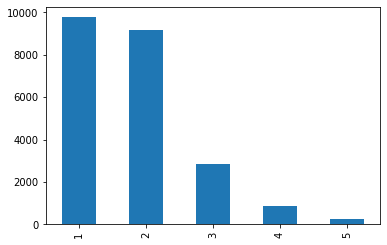

In [70]:
# real distribution - 5 classes 
observation2['elr_bin5_class'].value_counts().plot(kind = 'bar')

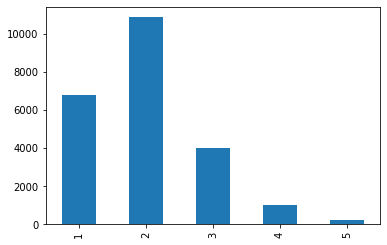

In [93]:
# predicted distribution - 5 classes
observation2['elr_bin5_class_hat'].value_counts().sort_index().plot(kind = 'bar')

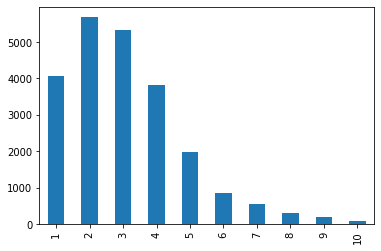

In [95]:
# real distribution - 10 classes
observation2['elr_bin10_class'].value_counts().sort_index().plot(kind = 'bar')

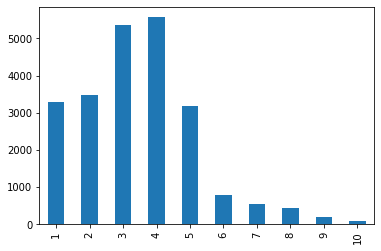

In [96]:
# predicted distribution - 10 classes 
observation2['elr_bin10_class_hat'].value_counts().sort_index().plot(kind = 'bar')

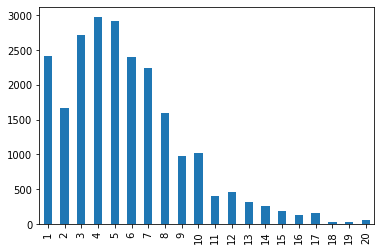

In [105]:
# real distribution - 20 classes
observation2['elr_bin20_class'].value_counts().sort_index().plot(kind = 'bar')

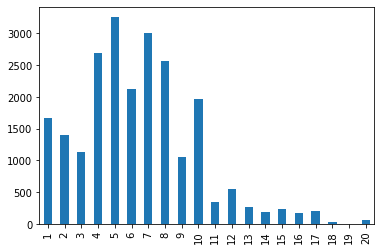

In [106]:
# predicted distribution - 20 classes
observation2['elr_bin20_class_hat'].value_counts().sort_index().plot(kind = 'bar')

### dataset exploration - interesting findings (sub1)

In [63]:
# examine the estimated loss rate for thoese who are not funded at all
zero_fund = sub1.loc[sub1['percent_funded'] == 0]
elr_zero_fund = zero_fund['estimated_loss_rate']
elr_zero_fund.describe()

count    2256.000000
mean        0.055182
std         0.033165
min         0.002700
25%         0.032400
50%         0.049400
75%         0.074900
max         0.177500
Name: estimated_loss_rate, dtype: float64

In [64]:
# examine the estimated loss rate for thoese who are funded 100%
total_fund = sub1.loc[sub1['percent_funded'] == 100]
elr_total_fund = total_fund['estimated_loss_rate']
elr_total_fund.describe()

count    207215.000000
mean          0.057953
std           0.034466
min           0.002700
25%           0.032400
50%           0.052400
75%           0.077400
max           0.177500
Name: estimated_loss_rate, dtype: float64

In [65]:
# examine the estimated loss rate for thoese who are only partially funded
partial_fund = sub1.loc[(sub1['percent_funded'] != 100) & (sub1['percent_funded'] != 0)]
elr_partial_fund = partial_fund['estimated_loss_rate']
elr_partial_fund.describe()

count    629.000000
mean       0.085997
std        0.047754
min        0.002700
25%        0.047400
50%        0.079900
75%        0.122500
max        0.177500
Name: estimated_loss_rate, dtype: float64

### Random Forest Feature selections - may be used for dimensional reduction 

In [67]:
feature_names = X.columns.tolist()

In [68]:
feature_ranks = pd.DataFrame({'feature_names':feature_names,'scores': rfc.feature_importances_}, columns = ['feature_names', 'scores'])

In [69]:
feature_ranks = feature_ranks.sort_values(by = ['scores'], ascending = False)
feature_ranks.set_index('feature_names', inplace = True)

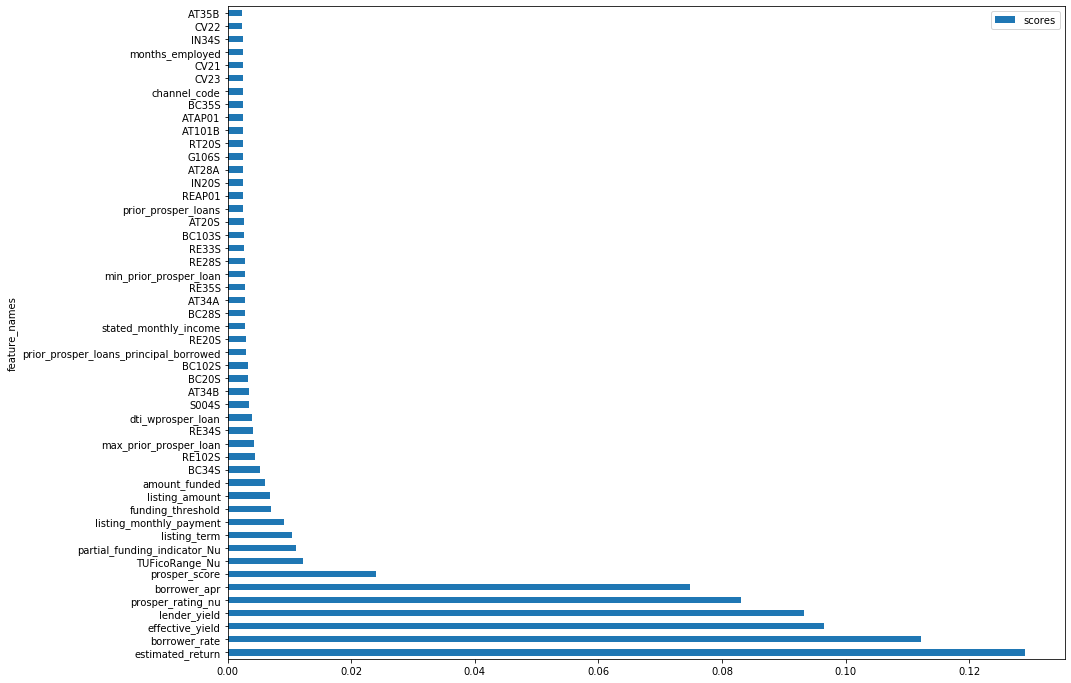

In [72]:
# visualize the top 50 importance features 
import matplotlib.pyplot as plt
feature_ranks.head(50).plot(kind = 'barh', figsize = (15,12))